In [2]:
import pandas as pd
import numpy as np
from tslearn.metrics import dtw
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import operator
from scipy import signal
from tqdm import tqdm
import matplotlib.pyplot as plt
from numpy import polyfit

In [172]:
# em for early_morning, ap for am_peak, noon for noon, pp for pm_peak, night for night.
interested_time_periods = {'em':['00:00','05:55'],
                           'ap':['06:00','10:55'],
                           'noon':['11:00','15:55'],
                           'pp':['16:00','20:55'],
                           'night':['21:00','23:55'],
                           'whole':['00:00','23:55'],
                           'smooth_ap':['05:00','11:55'],
                           'smooth_pp':['15:00','21:55']}

# the edge time periods defined below will be used at the final stage for smoothing.
edge_time_periods = {'em_t':['05:00','05:55'],
                     'noon_h':['11:00','11:55'],
                     'noon_t':['15:00','15:55'],
                     'night_h':['21:00','21:55']}

pd.set_option('display.max_rows', 500000)

In [5]:
def add_datetime_column_for_training_data(row):
    """add column datetime for a row in training dataframe.
    
    Parameters:
    row: a row in dataframe.
    
    Returns:
    date: datetime object.
    
    """
    date = datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S')
    return date

def add_datetime_column_for_test_data(row):
    """add column datetime for a row in test dataframe.
    
    Parameters:
    row: a row in dataframe.
    
    Returns:
    date: datetime object.
    
    """
    date = datetime.strptime(row['datetime'], '%H:%M:%S')
    return date

def add_day_of_datetime_column(row):
    """add column day of datetime for a row.
    
    Parameters:
    row: a row in dataframe.
    
    Returns:
    day_of_datetime: day of datetime, type int.
    
    """
    day_of_datetime = row['datetime'].day
    return day_of_datetime

def add_hour_and_min_column(row):
    """add column hour_and_min for a row.
    
    Parameters:
    row: a row in dataframe.
    
    Returns:
    hour_and_min: a string with format '%H:%M'.
    
    """
    hour_and_min = row['datetime'].strftime('%H:%M')
    return hour_and_min

def add_timestamp_column(row):
    """add column timestamp.
    
    Parameters:
    row: a row in dataframe.
    
    Returns:
    timestamp: a ordering measure of hour and minute in one day.
    
    """
    timestamp = row['datetime'].hour*12 + row['datetime'].minute/5
    return timestamp

In [232]:
def get_timestamp_for_particular_time_period(hour_min_start_end_list, data, day=None,timestamp_list=None):
    """get timestamps for given time period.
    
    Parameters:
    hour_min_start_end_list: a list with hour_min start as first element and hour_min end 
    as second element. Please refer to interested_time_periods at very beginning.
    data: dataframe to search.
    day: the day to search.
    timestamp_list: a list with timestamp start as first element and timestamp end as second
    element.
    
    Returns:
    numpy array of timestamps.
    
    """
    if timestamp_list==None:
        if day==None:
            output = data[(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
            return output['timestamp'].values
        else:
            output = data[(data['day_of_datetime']==day)&(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
            return output['timestamp'].values
    else:
        output = data[(data['timestamp']>=timestamp_list[0])&(data['timestamp']<=timestamp_list[1])]
        return output['timestamp'].values

def get_speed_data_for_particular_time_period(hour_min_start_end_list, data, day=None,type_of_speed='fitted_speed',timestamp_list=None):
    """get speed data of given time period.
    
    Parameters:
    hour_min_start_end_list: a list with hour_min start as first element and hour_min end 
    as second element. Please refer to interested_time_periods at very beginning.
    data: dataframe to search.
    day: the day to search.
    type_of_speed: "fitted_speed" is the speed already smoothed by polynomial curve, "speed"
    is the raw speed.
    timestamp_list: a list with timestamp start as first element and timestamp end as second
    element.
    
    Returns:
    numpy array of speeds.
    
    """
    if timestamp_list==None:
        if day==None:
            output = data[(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
            return output[type_of_speed].values
        else:
            output = data[(data['day_of_datetime']==day)&(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
            return output[type_of_speed].values
    else:
        output = data[(data['timestamp']>=timestamp_list[0])&(data['timestamp']<=timestamp_list[1])]
        return output[type_of_speed].values
 

In [1]:
def preprocess_training_data(data):
    """preprocess training data.
    
    Parameters:
    data: the training dataframe.
    
    Returns:
    data: the preprocessed training dataframe.
    
    """
    data['datetime'] = data.apply(lambda row:add_datetime_column_for_training_data(row),axis=1)
    data['day_of_datetime'] = data.apply(lambda row:add_day_of_datetime_column(row),axis=1,result_type='expand')
    data['hour_and_min'] = data.apply(lambda row:add_hour_and_min_column(row),axis=1,result_type='expand')
    data['timestamp'] = data.apply(lambda row:add_timestamp_column(row),axis=1,result_type='expand')
    data['fitted_speed'] = None
    data = data.drop(data[data['day_of_datetime']==31].index)
    return data

def preprocess_test_data(data):
    """preprocess test data.
    
    Parameters:
    data: the test dataframe.
    
    Returns:
    data: the preprocessed test dataframe.
    
    """
    data['datetime'] = data.apply(lambda row:add_datetime_column_for_test_data(row),axis=1)
    data['hour_and_min'] = data.apply(lambda row:add_hour_and_min_column(row),axis=1,result_type='expand')
    data['timestamp'] = data.apply(lambda row:add_timestamp_column(row),axis=1,result_type='expand')
    data['fitted_speed'] = None
    return data

In [188]:
def make_weights_for_polynomial_fitting(df_test,weight_controller=20,is_ap=True):
    """generate weights for polynomial fitting (smoothing).
    
    Parameters:
    df_test: test dataframe.
    weight_controller: the controller of weights distribution, one hour before and after
    the target timespan is considered, the larger the more weights assigned to data points
    near target timespan.
    is_ap: whether the target is am peak hours, true for yes, false for pm peak hours.
    
    Returns:
    weights_smooth_ap/weights_smooth_pp: the list of weights.
    
    """
    n_of_data = len(df_test)
    em_t_timestamp = get_timestamp_for_particular_time_period(edge_time_periods['em_t'], df_test, day=None)
    em_t_timestamp = em_t_timestamp.astype(int)
    noon_h_timestamp = get_timestamp_for_particular_time_period(edge_time_periods['noon_h'], df_test, day=None)
    noon_h_timestamp = noon_h_timestamp.astype(int)
    noon_t_timestamp = get_timestamp_for_particular_time_period(edge_time_periods['noon_t'], df_test, day=None)
    noon_t_timestamp = noon_t_timestamp.astype(int)
    night_h_timestamp = get_timestamp_for_particular_time_period(edge_time_periods['night_h'], df_test, day=None)
    night_h_timestamp = night_h_timestamp.astype(int)
    weights_for_em_t = np.linspace(1,weight_controller,num=len(em_t_timestamp))
    weights_for_noon_h = np.linspace(weight_controller,1,num=len(noon_h_timestamp))
    weights_for_noon_t = np.linspace(1,weight_controller,num=len(noon_t_timestamp))
    weights_for_night_h = np.linspace(weight_controller,1,num=len(night_h_timestamp))
    weights = np.ones(n_of_data)
    weights[em_t_timestamp[0]:em_t_timestamp[-1]+1] = weights_for_em_t
    weights[noon_h_timestamp[0]:noon_h_timestamp[-1]+1] = weights_for_noon_h
    weights[noon_t_timestamp[0]:noon_t_timestamp[-1]+1] = weights_for_noon_t
    weights[night_h_timestamp[0]:night_h_timestamp[-1]+1] = weights_for_night_h
    if is_ap:
        smooth_ap_timestamp = get_timestamp_for_particular_time_period(interested_time_periods['smooth_ap'], df_test, day=None)
        smooth_ap_timestamp = smooth_ap_timestamp.astype(int)
        weights_smooth_ap = weights[smooth_ap_timestamp[0]:smooth_ap_timestamp[-1]+1]
        return weights_smooth_ap
    else:
        smooth_pp_timestamp = get_timestamp_for_particular_time_period(interested_time_periods['smooth_pp'], df_test, day=None)
        smooth_pp_timestamp = smooth_pp_timestamp.astype(int)
        weights_smooth_pp = weights[smooth_pp_timestamp[0]:smooth_pp_timestamp[-1]+1]
        return weights_smooth_pp        

In [241]:
def fit_speed_with_curve_and_add_fitted_values_to_df(hour_min_start_end_list,data,df_ground_truth=None,fit_type='train',degree_train_=10,degree_test_=5,weight_controller_=None):
    """smoothing speed with polynomial curve.
    
    Parameters:
    hour_min_start_end_list: a list with hour_min start as first element and hour_min end.
    data: the dataframe the speed is fitted on.
    df_ground_truth: the ground truth dataframe of test data.
    fit_type: three modes. "train", "test_fit", or "final_smoothing".
    degree_train: the degree of polynomial curve to fit training data.
    degree_test: the degree of polynomial curve to fit test data.
    weight_controller_: the controller of weights distribution, one hour before and after
    the target timespan is considered, the larger the more weights assigned to data points
    near target timespan.
    
    Returns:
    data: the changed version of input dataframe with some columns created or revised.
    """
    if fit_type=='train':
        for day in data['day_of_datetime'].unique():
            target_df = data[(data['day_of_datetime']==day)&(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
            index = target_df.index
            x = get_timestamp_for_particular_time_period(hour_min_start_end_list, target_df, day=day)
            y = get_speed_data_for_particular_time_period(hour_min_start_end_list, target_df, day=day,type_of_speed='speed')
            coefficients = polyfit(x,y,degree_train_)
            f = np.poly1d(coefficients)
            speed_fitted = f(x)
            data.loc[index,'fitted_speed'] = speed_fitted
    elif fit_type=='test_fit':
        target_df = data[(data['hour_and_min']>=hour_min_start_end_list[0])&(data['hour_and_min']<=hour_min_start_end_list[1])]
        index = target_df.index
        x = get_timestamp_for_particular_time_period(hour_min_start_end_list, target_df, day=None)
        y = get_speed_data_for_particular_time_period(hour_min_start_end_list, target_df, day=None,type_of_speed='speed')
        coefficients = polyfit(x,y,degree_test_)
        f = np.poly1d(coefficients)
        speed_fitted = f(x)
        data.loc[index,'fitted_speed'] = speed_fitted
    elif fit_type=='final_smoothing':
        target_df_smooth_ap = data[(data['hour_and_min']>=interested_time_periods['smooth_ap'][0])&(data['hour_and_min']<=interested_time_periods['smooth_ap'][1])]
        target_df_smooth_pp = data[(data['hour_and_min']>=interested_time_periods['smooth_pp'][0])&(data['hour_and_min']<=interested_time_periods['smooth_pp'][1])]

        index_smooth_ap = target_df_smooth_ap.index
        index_smooth_pp = target_df_smooth_pp.index
        
        x_smooth_ap = get_timestamp_for_particular_time_period(interested_time_periods['smooth_ap'], target_df_smooth_ap, day=None)
        x_smooth_pp = get_timestamp_for_particular_time_period(interested_time_periods['smooth_pp'], target_df_smooth_pp, day=None)

        y_smooth_ap = get_speed_data_for_particular_time_period(interested_time_periods['smooth_ap'], target_df_smooth_ap, day=None,type_of_speed='fitted_speed')
        y_smooth_pp = get_speed_data_for_particular_time_period(interested_time_periods['smooth_pp'], target_df_smooth_pp, day=None,type_of_speed='fitted_speed')
        
        weights_smooth_ap = make_weights_for_polynomial_fitting(data,weight_controller=weight_controller_,is_ap=True)
        weights_smooth_pp = make_weights_for_polynomial_fitting(data,weight_controller=weight_controller_,is_ap=False)
        
        coefficients_smooth_ap = polyfit(x_smooth_ap,y_smooth_ap,degree_test_,w=weights_smooth_ap)
        coefficients_smooth_pp = polyfit(x_smooth_pp,y_smooth_pp,degree_test_,w=weights_smooth_pp)
        
        f_smooth_ap = np.poly1d(coefficients_smooth_ap)
        f_smooth_pp = np.poly1d(coefficients_smooth_pp)
        
        speed_smooth_ap = f_smooth_ap(x_smooth_ap)
        speed_smooth_pp = f_smooth_pp(x_smooth_pp)

        plt.plot(x_smooth_ap, y_smooth_ap, 'g.',x_smooth_pp, y_smooth_pp, 'g.')
        plt.plot(x_smooth_ap, f_smooth_ap(x_smooth_ap), 'r-',x_smooth_pp, f_smooth_pp(x_smooth_pp), 'r-')
        
        if df_ground_truth is not None:
            x_ground_truth = get_timestamp_for_particular_time_period(interested_time_periods['whole'], df_ground_truth, day=None)
            y_ground_truth = get_speed_data_for_particular_time_period(interested_time_periods['whole'], df_ground_truth, day=None,type_of_speed='speed')
            plt.plot(x_ground_truth, y_ground_truth,'.')
        plt.ylim(0,70)
        plt.title('the polinomial fitting for {} with degree: {}'.format(hour_min_start_end_list,degree_test_))
        plt.show()
        
        data.loc[index_smooth_ap,'fitted_speed'] = speed_smooth_ap
        data.loc[index_smooth_pp,'fitted_speed'] = speed_smooth_pp
        
    return data
    

In [137]:
def knn(df,sorted_am_similarity,sorted_pm_similarity,knn_weight,k=3,task='ap'):
    """an implementation of KNN for only one timespan.
    
    Parameters:
    df: dataframe to work on.
    sorted_am_similarity: sorted am similarity dictionary with days as keys and list of 
    similarity_em,similarity_noon,similarity_night as values.
    sorted_pm_similarity: sorted pm similarity dictionary with days as keys and list of 
    similarity_em,similarity_noon,similarity_night as values.
    knn_weight: the weights for K neighbors when making predictions.
    k: the number of neighbors.
    task: two modes. 'ap' for am peak hours, 'pp' for pm peak hours.
    
    Returns:
    average_predict: list of predicted speed.
    
    """
    predict_speed = []
    if task=='ap':
        sorted_similarity = sorted_am_similarity
    else:
        sorted_similarity = sorted_pm_similarity
    for row in sorted_similarity[:k]:
        day = int(row[0])
        speed = get_speed_data_for_particular_time_period(interested_time_periods[task],data=df,day=day,type_of_speed='fitted_speed')
        predict_speed.append(speed)
    predict_speed = np.array(predict_speed,dtype='float')
    # try weights here
    average_predict = np.average(predict_speed,axis=0,weights=knn_weight)
    return average_predict

In [151]:
def fill_in_test_data(df_test,predicted_am_peak_speed,predicted_pm_peak_speed,sorted_am_similarity,sorted_pm_similarity):
    """fill in blank boxes in prediction file.
    
    Parameters:
    df_test: test dataframe.
    predicted_am_peak_speed: the predicted speed of am peak hours to fill in.
    predicted_pm_peak_speed: the predicted speed of pm peak hours to fill in.
    sorted_am_similarity: sorted am similarity dictionary with days as keys and list of 
    similarity_em,similarity_noon,similarity_night as values.
    sorted_pm_similarity: sorted pm similarity dictionary with days as keys and list of 
    similarity_em,similarity_noon,similarity_night as values.
    
    Returns:
    df_test: the test dataframe filled with predicted speed.
    
    """
    am_index_to_fill = df_test[(df_test['hour_and_min']>=interested_time_periods['ap'][0])
                               &(df_test['hour_and_min']<=interested_time_periods['ap'][1])].index
    pm_index_to_fill = df_test[(df_test['hour_and_min']>=interested_time_periods['pp'][0])
                               &(df_test['hour_and_min']<=interested_time_periods['pp'][1])].index
    df_test.loc[am_index_to_fill,'fitted_speed'] = predicted_am_peak_speed
    df_test.loc[pm_index_to_fill,'fitted_speed'] = predicted_pm_peak_speed
    return df_test

In [141]:
def generate_knn_weights(k):
    """genera the weights for K neighbors when they are averaged to make predictions.
    
    note:
    the uniform weights proved to be most effective so other forms of weights are 
    commented out for the purpose of time saving.
    
    Parameters:
    k: number of neighbors.
    
    Returns:
    weights_1: returned list of weights for K neighbors.
    
    """
    weights_1 = np.ones(k)
    #weights_2 = np.array(range(k,0,-1))
    #weights_3 = np.array([1/i for i in range(1,k+1)])
    #normalize
    weights_1 = [i/sum(weights_1) for i in weights_1]
    #weights_2 = [i/sum(weights_2) for i in weights_2]
    #weights_3 = [i/sum(weights_3) for i in weights_3]
    return weights_1

In [142]:
generate_knn_weights(4)

[0.25, 0.25, 0.25, 0.25]

In [35]:
def generate_similarity_weights():
    """generate seven kinds of weights for two similarity features.
    
    note:
    as two similarity features (e.g., em_similarity and noon_similarity) are used to 
    decide which instances to be treated as neighbors, the weights of them is used to
    calculate the one and only one similarity measurement.
    
    Returns:
    [weights_1,weights_2,weights_3,weights_4,weights_5,weights_6,weights_7]: a list of
    different forms of similarity weights.
    
    """
    weights_1 = np.ones(2)
    weights_2 = np.array(range(2,0,-1))
    weights_3 = np.array(range(1,3))
    weights_4 = np.array([1/(i**2) for i in range(1,3)])
    weights_5 = np.array([1/(i**2) for i in range(2,0,-1)])
    
    weights_1 = [i/sum(weights_1) for i in weights_1]
    weights_2 = [i/sum(weights_2) for i in weights_2]
    weights_3 = [i/sum(weights_3) for i in weights_3]
    weights_4 = [i/sum(weights_4) for i in weights_4]
    weights_5 = [i/sum(weights_5) for i in weights_5]
    weights_6 = [1,0]
    weights_7 = [0,1]
    return [weights_1,weights_2,weights_3,weights_4,weights_5,weights_6,weights_7]
    
    

In [36]:
generate_similarity_weights()

[[0.5, 0.5],
 [0.6666666666666666, 0.3333333333333333],
 [0.3333333333333333, 0.6666666666666666],
 [0.8, 0.2],
 [0.2, 0.8],
 [1, 0],
 [0, 1]]

In [90]:
def get_score(df_ground_truth,predicted_test_data):
    """get the final score of prediction.
    
    Parameters:
    df_ground_truth: ground truth dataframe.
    predicted_test_data: the test dataframe with predicted speed filled in.
    
    Returns:
    mse: Mean Square Error.
    mae: Mean Absolute Error.
    
    """
    am_speed_ground_truth = get_speed_data_for_particular_time_period(interested_time_periods['ap'],data=df_ground_truth,day=None,type_of_speed='speed')
    pm_speed_ground_truth = get_speed_data_for_particular_time_period(interested_time_periods['pp'],data=df_ground_truth,day=None,type_of_speed='speed')
    am_speed_predicted = get_speed_data_for_particular_time_period(interested_time_periods['ap'],data=predicted_test_data,day=None,type_of_speed='fitted_speed')
    pm_speed_predicted = get_speed_data_for_particular_time_period(interested_time_periods['pp'],data=predicted_test_data,day=None,type_of_speed='fitted_speed')
    speed_ground_truth = np.concatenate((am_speed_ground_truth,pm_speed_ground_truth))
    speed_predicted = np.concatenate((am_speed_predicted,pm_speed_predicted))
    mse = mean_squared_error(speed_ground_truth,speed_predicted)
    mae = mean_absolute_error(speed_ground_truth,speed_predicted)
    return mse,mae

In [91]:
def get_similarity_to_history(df,df_test,similarity_measure='dtw'):
    """get similarity dictionary that measure similarity between the speeds in prediction 
    file and speed of days in history. 
    
    Parameters:
    df: training dataframe
    df_test: test dataframe
    similarity_measure: two modes. 'dtw' or 'mae'.
    
    Returns:
    similarity_to_history: similarity dictionary with days as keys and  list of similarity_em,
    similarity_noon,similarity_night as values.
    """
    similarity_measure_dict = {'dtw':dtw,'mae':mean_absolute_error}
    similarity_to_history = {}
    target_speed_em = get_speed_data_for_particular_time_period(interested_time_periods['em'],data=df_test,day=None,type_of_speed='fitted_speed')
    target_speed_noon = get_speed_data_for_particular_time_period(interested_time_periods['noon'],data=df_test,day=None,type_of_speed='fitted_speed')
    target_speed_night = get_speed_data_for_particular_time_period(interested_time_periods['night'],data=df_test,day=None,type_of_speed='fitted_speed')
    days_in_history = list(df['day_of_datetime'].unique())
    for day in days_in_history:
        speed_em = get_speed_data_for_particular_time_period(interested_time_periods['em'],data=df,day=day,type_of_speed='fitted_speed')
        speed_noon = get_speed_data_for_particular_time_period(interested_time_periods['noon'],data=df,day=day,type_of_speed='fitted_speed')
        speed_night = get_speed_data_for_particular_time_period(interested_time_periods['night'],data=df,day=day,type_of_speed='fitted_speed')
        similarity_em = similarity_measure_dict[similarity_measure](target_speed_em,speed_em)
        similarity_noon = similarity_measure_dict[similarity_measure](target_speed_noon,speed_noon)
        similarity_night = similarity_measure_dict[similarity_measure](target_speed_night,speed_night)
        similarity_to_history[str(day)] = [similarity_em,similarity_noon,similarity_night]
    return similarity_to_history

In [244]:
def knn_solution_validation(degree_train,degree_test,weight_controller=20,k=3,similarity_measure='dtw',smooth_window_size=11,smooth_degree=2,direction = 'south'):
    """the real implementation of proposed KNN-based model on validation sets.
    
    Parameters:
    degree_train: the degree of polynomial curve to smooth training data.
    degree_test: the degree of polynomial curve to smooth test data.
    weight_controller: the controller of weights distribution, one hour before and after
    the target timespan is considered, the larger the more weights assigned to data points
    near target timespan.
    k: number of neighbors
    similarity_measure: two modes. 'dtw' or 'mae'.
    smooth_window_size: deprecated, previously another smoothing technique rather polynomial 
    smoothing is used. And this variable belongs to that method.
    smooth_degree: deprecated, previously another smoothing technique rather polynomial 
    smoothing is used. And this variable belongs to that method.
    direction: 'north' for predict speed of Northbound, 'south' for Southbound.
    
    Returns:
    mse_average: the average Mean Square Error on seven folds of training/validationg sets.
    mae_average: the average Mean Absolute Error on seven folds of training/validationg sets.
    
    """
    mses = []
    maes = []
    for fold in range(1,8):
        file_directory = 'validation//{}//'.format(direction)
        training_file_name = 'training_data_fold{}.csv'.format(fold)
        file_to_open = file_directory + training_file_name
        df = pd.read_csv(file_to_open)
        df = preprocess_training_data(df)
        df = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods['whole'],df,fit_type='train',degree_train_=degree_train)

        test_file_name = 'test_data_fold{}.csv'.format(fold)
        file_to_open = file_directory + test_file_name
        df_test = pd.read_csv(file_to_open)
        df_test = preprocess_test_data(df_test)
        for time_period in ['em','noon','night']:
            df_test = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods[time_period],df_test,fit_type='test_fit',degree_test_=degree_test)
        
        file_directory = 'validation//{}//ground_truth_for_test//'.format(direction)
        ground_truth_file_name = 'test_data_fold{}_answer.csv'.format(fold)
        file_to_open = file_directory + ground_truth_file_name
        df_ground_truth = pd.read_csv(file_to_open)
        df_ground_truth = preprocess_training_data(df_ground_truth)

        similarity_to_history = get_similarity_to_history(df,df_test,similarity_measure)

        am_similarity = {}
        for key,value in similarity_to_history.items():
            am_similarity[key] = value[0]+ value[1]
        pm_similarity = {}
        for key,value in similarity_to_history.items():
            pm_similarity[key] = value[1] + value[2]
            
        sorted_am_similarity = sorted(am_similarity.items(), key=operator.itemgetter(1))
        sorted_pm_similarity = sorted(pm_similarity.items(), key=operator.itemgetter(1))

        knn_weights = generate_knn_weights(k)
        predicted_test_data = fill_in_test_data(df_test,
                                                knn(df,sorted_am_similarity,sorted_pm_similarity,knn_weights,k,task='ap'),
                                                knn(df,sorted_am_similarity,sorted_pm_similarity,knn_weights,k,task='pp'),
                                                sorted_am_similarity,
                                                sorted_pm_similarity)

        #predicted_test_data['speed'] = signal.savgol_filter(predicted_test_data['speed'],smooth_window_size,smooth_degree)
        predicted_test_data = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods['whole'],
                                                                               predicted_test_data,df_ground_truth,fit_type='final_smoothing',
                                                                               degree_train_=degree_train,degree_test_=degree_test,weight_controller_ = weight_controller)
        mse,mae = get_score(df_ground_truth,predicted_test_data)    

        mses.append(mse)
        maes.append(mae)
        mse_average = np.average(mses)
        mae_average = np.average(maes)
    return mse_average,mae_average

In [247]:
def knn_solution_real_test(degree_train,degree_test,weight_controller=20,k=3,similarity_measure='dtw',smooth_window_size=11,smooth_degree=2,direction = 'south'):
    """the real implementation of proposed KNN-based model on test sets (results for competition).
    
    Parameters:
    degree_train: the degree of polynomial curve to smooth training data.
    degree_test: the degree of polynomial curve to smooth test data.
    weight_controller: the controller of weights distribution, one hour before and after
    the target timespan is considered, the larger the more weights assigned to data points
    near target timespan.
    k: number of neighbors
    similarity_measure: two modes. 'dtw' or 'mae'.
    smooth_window_size: deprecated, previously another smoothing technique rather polynomial 
    smoothing is used. And this variable belongs to that method.
    smooth_degree: deprecated, previously another smoothing technique rather polynomial 
    smoothing is used. And this variable belongs to that method.
    direction: 'north' for predict speed of Northbound, 'south' for Southbound.
    
    Returns:
    None
    
    """    
    file_directory = 'prediction//to_{}_historical_road_speed_cleaned.csv'.format(direction)
    df = pd.read_csv(file_directory)
    df = preprocess_training_data(df)
    df = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods['whole'],df,fit_type='train',degree_train_=degree_train)

    test_file_name = 'prediction//cleaned_Predictions_{}.csv'.format(direction)
    df_test = pd.read_csv(test_file_name)
    df_test = preprocess_test_data(df_test)
    for time_period in ['em','noon','night']:
        df_test = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods[time_period],df_test,fit_type='test_fit',degree_test_=degree_test)


    similarity_to_history = get_similarity_to_history(df,df_test,similarity_measure)

    am_similarity = {}
    for key,value in similarity_to_history.items():
        am_similarity[key] = value[0]+ value[1]
    pm_similarity = {}
    for key,value in similarity_to_history.items():
        pm_similarity[key] = value[1] + value[2]

    sorted_am_similarity = sorted(am_similarity.items(), key=operator.itemgetter(1))
    sorted_pm_similarity = sorted(pm_similarity.items(), key=operator.itemgetter(1))

    knn_weights = generate_knn_weights(k)
    predicted_test_data = fill_in_test_data(df_test,
                                            knn(df,sorted_am_similarity,sorted_pm_similarity,knn_weights,k,task='ap'),
                                            knn(df,sorted_am_similarity,sorted_pm_similarity,knn_weights,k,task='pp'),
                                            sorted_am_similarity,
                                            sorted_pm_similarity)

    #predicted_test_data['speed'] = signal.savgol_filter(predicted_test_data['speed'],smooth_window_size,smooth_degree)
    predicted_test_data = fit_speed_with_curve_and_add_fitted_values_to_df(interested_time_periods['whole'],
                                                                           predicted_test_data,df_ground_truth=None,fit_type='final_smoothing',
                                                                           degree_train_=degree_train,degree_test_=degree_test,weight_controller_ = weight_controller)
    predicted_test_data.to_csv('prediction//prediction_output_{}.csv'.format(direction))
    return None

In [200]:
# Validation and grid search on different combinations of hyperparameters for northbound.
results_north = pd.DataFrame(columns=['degree_train','degree_test','k','weight_controller','mse','mae'])
for k in tqdm(range(3,6)):
    for weight_controller in range(1,10,2):
        for degree_train in range(5,20,2):
            for degree_test in range(3,15,2):
                mse,mae = knn_solution(degree_train,degree_test,weight_controller,k,direction='north')
                result_df = pd.DataFrame([[degree_train,degree_test,k,weight_controller,mse,mae]],columns=['degree_train','degree_test','k','weight_controller','mse','mae'])
                results_north = results_north.append(result_df,ignore_index =True)




  0%|                                                                                            | 0/3 [00:00<?, ?it/s]D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be p

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly c

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poor

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit ma

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned



 67%|████████████████████████████████████████████████████                          | 2/3 [2:06:02<1:02:55, 3775.90s/it]D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit ma

In [201]:
# show the validation result for northbound.
results_north.sort_values(by='mse')

degree_train degree_test  k weight_controller        mse       mae
524           19           7  5                 1  31.640133  4.299198
512           15           7  5                 1  31.821850  4.388282
513           15           9  5                 1  31.872120  4.405039
279           17           9  4                 1  31.882526  4.341361
499           11           5  5                 1  31.931162  4.300013
265           13           5  4                 1  31.957700  4.350560
525           19           9  5                 1  32.063168  4.342677
519           17           9  5                 1  32.122365  4.376744
259           11           5  4                 1  32.126572  4.298165
521           17          13  5                 1  32.185480  4.380645
514           15          11  5                 1  32.309794  4.424615
527           19          13  5                 1  32.480213  4.322192
507           13           9  5                 1  32.497252  4.409294
267           13           9  4                 1  32.528818  4.415282
20            11           7  3                 1  32.541158  4.351445
268           13          11  4                 1  32.565123  4.398930
501           11           9  5                 1  32.598102  4.416766
280           17          11  4                 1  32.615746  4.400753
260           11           7  4                 1  32.671477  4.396015
520           17          11  5                 1  32.747036  4.443528
515           15          13  5                 1  32.751295  4.436318
273           15           9  4                 1  32.756505  4.453470
25            13           5  3                 1  32.764956  4.389050
503           11          13  5                 1  32.807378  4.398471
523           19           5  5                 1  32.831998  4.434237
526           19          11  5                 1  32.836844  4.393516
518           17           7  5                 1  32.838644  4.463944
505           13           5  5                 1  32.840226  4.449872
261           11           9  4                 1  32.850826  4.432617
269           13          13  4                 1  32.916977  4.381866
277           17           5  4                 1  32.934788  4.436407
506           13           7  5                 1  32.946055  4.452927
498           11           3  5                 1  32.952544  4.319326
502           11          11  5                 1  32.973742  4.451342
278           17           7  4                 1  33.086936  4.440448
500           11           7  5                 1  33.088600  4.454085
19            11           5  3                 1  33.102128  4.423374
21            11           9  3                 1  33.115735  4.436252
45            19           9  3                 1  33.153688  4.400348
511           15           5  5                 1  33.171213  4.528602
274           15          11  4                 1  33.191709  4.472543
281           17          13  4                 1  33.200886  4.454800
286           19          11  4                 1  33.205984  4.382371
43            19           5  3                 1  33.269720  4.409818
22            11          11  3                 1  33.330013  4.438968
517           17           5  5                 1  33.334247  4.468438
282           19           3  4                 1  33.369466  4.411783
272           15           7  4                 1  33.380098  4.503643
313           13           5  4                 3  33.388797  4.423081
508           13          11  5                 1  33.415583  4.490846
285           19           9  4                 1  33.449341  4.415526
262           11          11  4                 1  33.473528  4.507282
547           11           5  5                 3  33.475507  4.389455
23            11          13  3                 1  33.477254  4.415720
307           11           5  4                 3  33.644447  4.379624
263           11          13

In [202]:
# Validation and grid search on different combinations of hyperparameters for southbound.
results_south = pd.DataFrame(columns=['degree_train','degree_test','k','weight_controller','mse','mae'])
for k in tqdm(range(3,6)):
    for weight_controller in range(1,10,2):
        for degree_train in range(5,20,2):
            for degree_test in range(3,15,2):
                mse,mae = knn_solution(degree_train,degree_test,weight_controller,k,direction='south')
                result_df = pd.DataFrame([[degree_train,degree_test,k,weight_controller,mse,mae]],columns=['degree_train','degree_test','k','weight_controller','mse','mae'])
                results_south = results_south.append(result_df,ignore_index =True)




  0%|                                                                                            | 0/3 [00:00<?, ?it/s]D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be p

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly c

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poor

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit ma

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned



 67%|████████████████████████████████████████████████████                          | 2/3 [2:05:53<1:02:53, 3773.78s/it]D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be 

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be po

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:49: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly cond

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may b

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit may be poorly conditioned
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:50: RankWarning: Polyfit may be

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:23: RankWarning: Polyfit ma

In [203]:
# show the validation result for southbound.
results_south.sort_values(by='mse')

degree_train degree_test  k weight_controller        mse       mae
527           19          13  5                 1  25.899271  3.653603
526           19          11  5                 1  25.914332  3.656443
271           15           5  4                 1  26.101880  3.640099
521           17          13  5                 1  26.142583  3.675542
517           17           5  5                 1  26.142725  3.664959
523           19           5  5                 1  26.168094  3.649976
262           11          11  4                 1  26.256657  3.733082
505           13           5  5                 1  26.290887  3.700447
524           19           7  5                 1  26.303983  3.648972
22            11          11  3                 1  26.309598  3.739732
518           17           7  5                 1  26.322156  3.656082
520           17          11  5                 1  26.346386  3.702359
277           17           5  4                 1  26.346940  3.681122
281           17          13  4                 1  26.354702  3.717283
31            15           5  3                 1  26.385759  3.678814
515           15          13  5                 1  26.409539  3.691063
265           13           5  4                 1  26.409857  3.678147
565           17           5  5                 3  26.432489  3.660764
319           15           5  4                 3  26.438557  3.638017
511           15           5  5                 1  26.446538  3.667040
32            15           7  3                 1  26.451295  3.667853
519           17           9  5                 1  26.473727  3.693843
571           19           5  5                 3  26.498590  3.647909
502           11          11  5                 1  26.537785  3.758569
514           15          11  5                 1  26.558399  3.698107
574           19          11  5                 3  26.578641  3.701688
263           11          13  4                 1  26.584070  3.773993
553           13           5  5                 3  26.590264  3.697637
285           19           9  4                 1  26.593034  3.712941
34            15          11  3                 1  26.598837  3.709338
525           19           9  5                 1  26.624219  3.693191
503           11          13  5                 1  26.629407  3.764046
279           17           9  4                 1  26.631725  3.718617
575           19          13  5                 3  26.644267  3.702363
512           15           7  5                 1  26.647583  3.669255
325           17           5  4                 3  26.647710  3.678244
272           15           7  4                 1  26.651716  3.679453
28            13          11  3                 1  26.653772  3.728473
274           15          11  4                 1  26.702152  3.712073
79            15           5  3                 3  26.706687  3.678859
499           11           5  5                 1  26.737322  3.755416
35            15          13  3                 1  26.745545  3.717454
313           13           5  4                 3  26.747478  3.678352
493            9           5  5                 1  26.778669  3.764230
559           15           5  5                 3  26.787889  3.666476
43            19           5  3                 1  26.790406  3.706395
259           11           5  4                 1  26.792651  3.780968
23            11          13  3                 1  26.796480  3.800362
310           11          11  4                 3  26.810555  3.764926
569           17          13  5                 3  26.820717  3.716528
286           19          11  4                 1  26.832916  3.744488
283           19           5  4                 1  26.837587  3.700932
284           19           7  4                 1  26.854992  3.691799
19            11           5  3                 1  26.862343  3.768581
253            9           5  4                 1  26.870064  3.772189
541            9           5

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

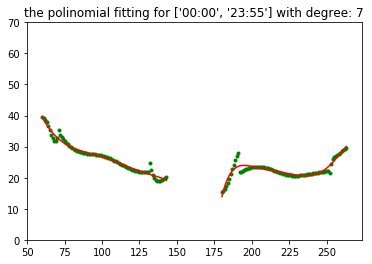

In [248]:
# use the optimal hyperparameters to make predictions for northbound.
knn_solution_real_test(19,7,weight_controller=1,k=5,similarity_measure='dtw',smooth_window_size=11,smooth_degree=2,direction='north')

D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may be poorly conditioned
  
D:\software\Anaconda\lib\site-packages\ipykernel_launcher.py:8: RankWarning: Polyfit may

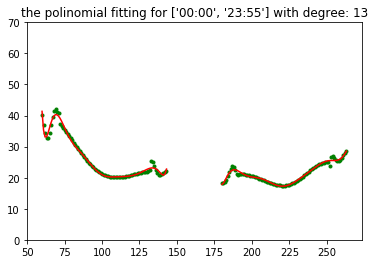

In [250]:
# use the optimal hyperparameters to make predictions for southbound.
knn_solution_real_test(19,13,weight_controller=1,k=5,similarity_measure='dtw',smooth_window_size=11,smooth_degree=2,direction = 'south')

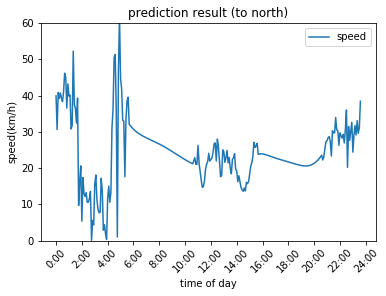

In [6]:
# plot the prediction results of Northbound.
prediction_data_north = pd.read_csv('Predictions_north.csv')
prediction_data_north.plot('time','speed')
plt.xticks(np.linspace(0, 288, num=13), ['{}:00'.format(i) for i in np.arange(0,25,step=2)],rotation=45)
plt.xlabel('time of day')
plt.ylabel('speed(km/h)')
plt.ylim(0,60)
plt.title('prediction result (to north)')
plt.savefig('prediction_north.png')

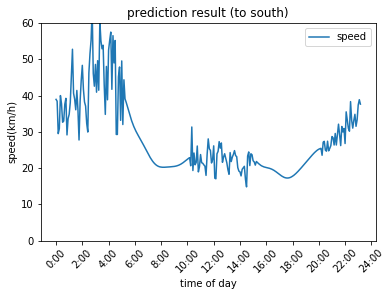

In [7]:
# plot the prediction results of Southbound.
prediction_data_south = pd.read_csv('Predictions_south.csv')
prediction_data_south.plot('time','speed')
plt.xticks(np.linspace(0, 288, num=13), ['{}:00'.format(i) for i in np.arange(0,25,step=2)],rotation=45)
plt.xlabel('time of day')
plt.ylabel('speed(km/h)')
plt.ylim(0,60)
plt.title('prediction result (to south)')
plt.savefig('prediction_south.png')